In [44]:
import time
import math
import numpy as np
import pandas as pd
import datetime
import scipy as sc
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

In [67]:
def get_data(stocks, start, end):
    df = yf.download(stocks,start, end)
    return df
endDate = datetime.datetime(2022,2,10)
startDate = endDate-datetime.timedelta(days = 7000)
stock_prices = get_data('^GSPC',startDate,endDate)
print(startDate)
stock_prices = stock_prices[['Adj Close']]
stock_prices.head(3)

[*********************100%***********************]  1 of 1 completed
2002-12-12 00:00:00


,Adj Close
Date,
2002-12-12,901.580017
2002-12-13,889.479980
2002-12-16,910.400024


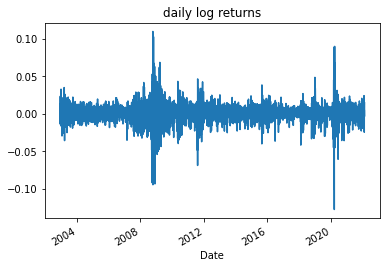

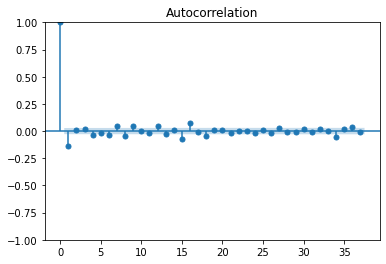

In [70]:
stock_prices = stock_prices['Adj Close']
log_returns = np.log(stock_prices/stock_prices.shift(1)).dropna()
log_returns.plot()
plt.title('daily log returns')
plot_acf(log_returns)
plt.show()

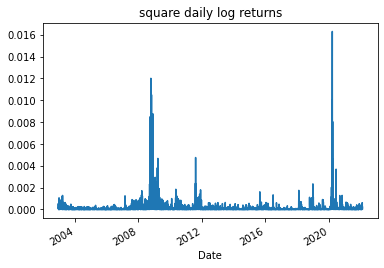

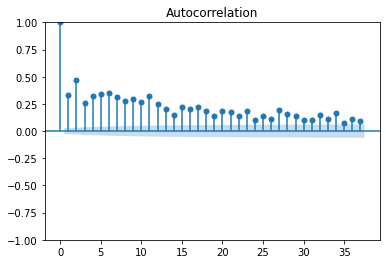

In [71]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('square daily log returns')
plot_acf(log_returns_sq)
plt.show()

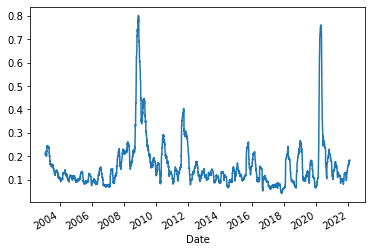

In [72]:
Trading_days = 40
vol = log_returns.rolling(window = Trading_days).std()*np.sqrt(252)
vol = vol.dropna()
vol.plot()
plt.show()

In [73]:
def MLE_norm(x):
    mu_hat = np.mean(x)
    sig2_hat = np.var(x)
    return mu_hat, sig2_hat
mu = 5
sig = 2.5
N = 10000
np.random.seed(0)
x = np.random.normal(loc = mu, scale = sig, size = (N,))
mu_hat, sig2_hat = MLE_norm(x)
print(mu_hat, np.sqrt(sig2_hat))

4.953915699604336 2.468891420440302


In [74]:
def log_likelihood(theta,x):
        mu = theta[0]
        sig = theta[1]
        l_theta = np.sum(np.log(sc.stats.norm.pdf(x, loc = mu, scale = sig)))
        return -l_theta
def sig_pos(theta):
    sig = theta[1]
    return sig

In [75]:
cons_set = {'type':'ineq','fun':sig_pos}
theta0 = [2,3]
opt = sc.optimize.minimize(fun = log_likelihood, x0 = theta0, args = (x,),constraints = cons_set)
mu_hat = round(opt.x[0],2)
sig_hat = round(opt.x[1],2)
print(mu_hat,sig_hat)

4.95 2.47


/tmp/ipykernel_844899/641195595.py:4: RuntimeWarning: divide by zero encountered in log
  l_theta = np.sum(np.log(sc.stats.norm.pdf(x, loc = mu, scale = sig)))


MLE of Ornstein-Uhlenbeck process

In [93]:
df = yf.download('^GSPC','2004-01-01','2023-07-01')
df = df['Adj Close']
def mean_rev(df,startDate,endDate):
    #def get_data(stocks, start, end):
    #    df = yf.download(stocks,start, end)
    #    return df
    #endDate = datetime.datetime(2022,2,10)
    #startDate = endDate-datetime.timedelta(days = 7000)
    #stock_prices = get_data('^GSPC',startDate,endDate)
    stock_prices = df[startDate:endDate]
    log_returns = np.log(stock_prices/stock_prices.shift(1)).dropna()
    Trading_days = 40
    vol = log_returns.rolling(window = Trading_days).std()*np.sqrt(252)
    vol = vol.dropna()
    def mu(x,dt,kappa,theta):
        ekt = np.exp(-kappa*dt)
        return x*ekt+theta*(1-ekt)
    def std(dt,kappa,sigma):
        ekt = np.exp(-kappa*2*dt)
        return sigma*np.sqrt((1-ekt)/(2*kappa))
    def log_likelihood_OU(theta_hat,x):
        kappa = theta_hat[0]
        theta = theta_hat[1]
        sigma = theta_hat[2]
        x_tdt = x[1:]
        x_t = x[:-1] 
        dt = 1/252
        mu_OU = mu(x_t,dt,kappa,theta)
        sigma_OU = std(dt,kappa,sigma)
        l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_tdt,loc = mu_OU, scale = sigma_OU)))
        return -l_theta_hat
    def kappa_pos(theta_hat):
        kappa = theta_hat[0]
        return kappa
    def sigma_pos(theta_hat):
        sigma = theta_hat[2]
        return sigma
    cons_set = [{'type':'ineq','fun':kappa_pos},
               {'type':'ineq', 'fun':sigma_pos}]
    theta0 = [1,1,1]
    opt = sc.optimize.minimize(fun = log_likelihood_OU, x0 = theta0, args = (vol,),
                              constraints = cons_set)
    return opt['x']
mean_rev(df,datetime.datetime(2022,2,10),datetime.datetime(2023,7,10))

[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_844899/4145739727.py:30: RuntimeWarning: divide by zero encountered in log
  l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_tdt,loc = mu_OU, scale = sigma_OU)))


array([1.57032914, 0.12344577, 0.17797154])

/tmp/ipykernel_844899/4145739727.py:30: RuntimeWarning: divide by zero encountered in log
  l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_tdt,loc = mu_OU, scale = sigma_OU)))
/tmp/ipykernel_844899/4145739727.py:20: RuntimeWarning: invalid value encountered in double_scalars
  return sigma*np.sqrt((1-ekt)/(2*kappa))
/tmp/ipykernel_844899/4145739727.py:19: RuntimeWarning: overflow encountered in exp
  ekt = np.exp(-kappa*2*dt)
/tmp/ipykernel_844899/4145739727.py:16: RuntimeWarning: overflow encountered in exp
  ekt = np.exp(-kappa*dt)


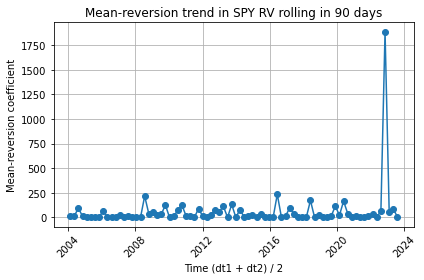

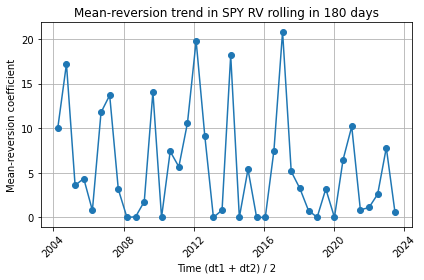

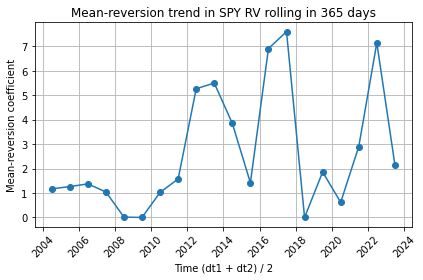

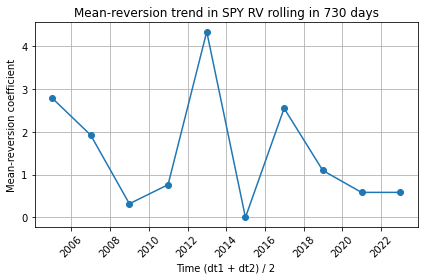

In [103]:
import datetime as dt
for ds in [90,180,365,730]:
    # Generate dt1 values from 2004-01-01 to 2023-07-01 at 6-month intervals
    start_date = dt.datetime(2004, 1, 1)
    end_date = dt.datetime(2023, 7, 1)
    delta = dt.timedelta(days=ds)  # 6 months
    dt1_values = []
    current_date = start_date
    while current_date <= end_date:
        dt1_values.append(current_date)
        current_date += delta

    # Calculate corresponding dt2 values (dt2 = dt1 + 6 months)
    dt2_values = [dt1 + delta for dt1 in dt1_values]

    # Compute the mean_rev output for each dt1 and dt2 pair
    mean_rev_outputs = [mean_rev(df,dt1, dt2)[0] for dt1, dt2 in zip(dt1_values, dt2_values)]

    # Calculate the x-values as (dt1 + dt2) / 2
    x_values = [(dt1 + (dt2 - dt1) / 2) for dt1, dt2 in zip(dt1_values, dt2_values)]

    # Create the plot
    plt.figure(figsize=(6, 4))
    plt.plot(x_values, mean_rev_outputs, marker='o', linestyle='-')
    plt.xlabel('Time (dt1 + dt2) / 2')
    plt.ylabel('Mean-reversion coefficient')
    plt.title('Mean-reversion trend in SPY RV rolling in '+str(ds)+' days')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()